In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
df_eng = pd.read_csv('/content/drive/My Drive/edited_topics_set2.csv')
df_beng = pd.read_csv('/content/drive/My Drive/edited_tag_bengali.csv')

In [8]:
#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

# vectorizing processed content

text_eng = df_eng['processed_content'].values
X_eng = vectorize(text_eng, 643)
X_eng.shape


(2155, 643)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X_eng.toarray())
X_reduced.shape

(2155, 467)

In [10]:
text_beng = df_beng['processed_tags'].values
X_beng = vectorize(text_beng, 467)
X_beng.shape

(316, 467)

Clustering task 

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# run kmeans with many different k
distortions = []
K = range(28, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X_eng.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 28 clusters
Found distortion for 29 clusters


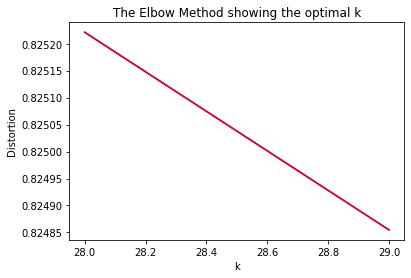

In [12]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [13]:
k = 30 #taking 30 clusters
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_eng['cluster'] = y_pred ##storing the corresponding clusters of each row

In [15]:
df_eng.to_csv('/content/drive/My Drive/eng_data_for_bengali.csv')

In [ ]:
# save the model in pickle file
import pickle


In [16]:
df_eng['cluster'].value_counts()

1     237
27    193
4     115
28    109
21    108
13    103
5      88
12     84
3      81
25     74
6      74
0      70
14     67
10     67
9      65
2      62
15     61
20     61
22     56
7      54
11     50
24     43
16     39
17     37
23     36
8      35
26     27
29     26
19     20
18     13
Name: cluster, dtype: int64

Multi-label Classification task

In [17]:
#Create Dependent and Independent Datasets based on our Dependent #and Independent features
X  = X_reduced
y= df_eng['cluster']
#Split the Data into Training and Testing sets with test size as #30%
X_train, y_train = X, y

X_test = X_beng
# we dont have y_test. We need to predict using classifier model

In [18]:
X_train.shape

(2155, 467)

In [19]:
y_train.shape

(2155,)

In [20]:
X_test.shape

(316, 467)

In [21]:
from sklearn.svm import LinearSVC

In [22]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
df_beng['cluster'] = y_pred

In [24]:
df_beng.head()

,Unnamed: 0,Unnamed: 0.1,_id,heading,publish_date,imagelink,tags,content,processed_tags,cluster
0,0,0,{'$oid': '5f0d4e9d4c97c6e27ca66cf3'},"['দেশে করোনা আক্রান্ত ন’লাখ ছাড়াল, ২৪ ঘণ্টায় ...","['১৪ জুলাই, ২০২০, ১০:৩০:০২']",['https://images.anandabazar.com/polopoly_fs/1...,"['Coronavirus', 'COVID-19', 'Coronavirus in In...",['লাফিয়ে লাফিয়ে বেড়ে ভারতে করোনাভাইরাসে আক্রা...,coronavirus covid coronavirus india,1
1,1,1,{'$oid': '5f0d4ea04c97c6e27ca66cf4'},"['অনেক দেশ ভুল পথে হাঁটছে, ফল মারাত্মক হবে, সত...","['১৪ জুলাই, ২০২০, ০৯:৫৪:১৪']",['https://images.anandabazar.com/polopoly_fs/1...,"['WHO', 'coronavirus']",[' বিষয়ে অনেক দেশই ভুল পথে হাঁটছে। ফলে সময়ের স...,coronavirus,20
2,2,2,{'$oid': '5f0d4ea34c97c6e27ca66cf5'},"['গহলৌতেই আস্থা, রফার খোঁজ প্রিয়ঙ্কার']","['১৪ জুলাই, ২০২০, ০৪:০১:৩৯']",['https://images.anandabazar.com/polopoly_fs/1...,"['Ashok Gehlot', 'Congress', 'Priyanka Gandhi ...",['মরু-রাজ্যে গোষ্ঠীদ্বন্দ্বের চোরাবালিতে কংগ্র...,ashok gehlot congress priyanka gandhi vadra,26
3,3,3,{'$oid': '5f0d4ea64c97c6e27ca66cf6'},"['হেমতাবাদের বিধায়কের মৃত্যুতে রহস্য, তদন্তে ...","['১৪ জুলাই, ২০২০, ০৪:০৭:৫১']",['https://images.anandabazar.com/polopoly_fs/1...,"['Death', 'BJP', 'MLA', 'Hemtabad', 'CID']",['উত্তর দিনাজপুরের হেমতাবাদের বিধায়ক দেব্রেন্দ...,death hemtabad,27
4,4,4,{'$oid': '5f0d4eaa4c97c6e27ca66cf7'},['কংগ্রেস হাইকমান্ডের কি আর দলের উপরে ‘কমান্ড’...,"['১৪ জুলাই, ২০২০, ০৩:৪৭:৫১']",['https://images.anandabazar.com/polopoly_fs/1...,"['Congress', 'Sonia Gandhi', 'Rahul Gandhi', '...",['আকবর রোডের ২৪ নম্বর বাংলো চত্বরে প্রশ্নটা ঘু...,congress sonia gandhi rahul gandhi sachin pilot,12


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


There are 28 news categories


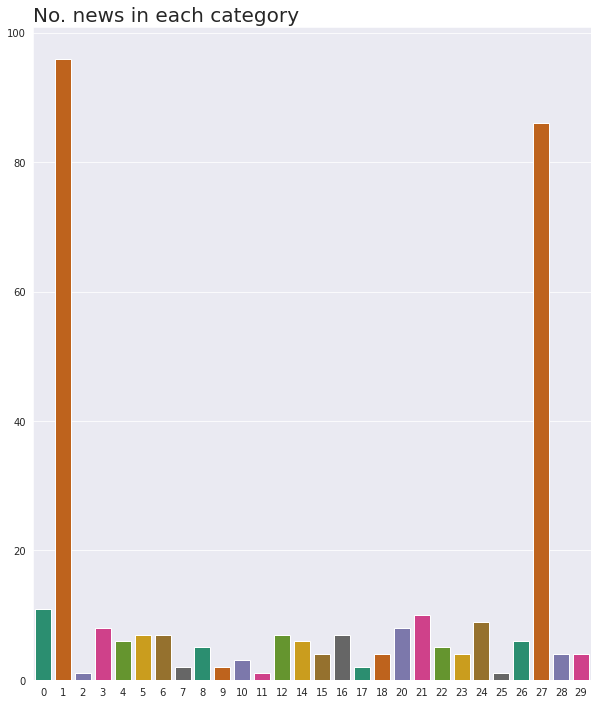

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


#No. of contents in each category
count_df = pd.DataFrame(df_beng['cluster'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='cluster', x='index', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [28]:
df_beng[df_beng.cluster == 22]

,Unnamed: 0,Unnamed: 0.1,_id,heading,publish_date,imagelink,tags,content,processed_tags,cluster
71,71,75,{'$oid': '5f193f5fb097d929e9eef251'},"['টিম ইন্ডিয়ার রূপান্তরের অনুঘটক সৌরভই, আমি ওর...","['২৩ জুলাই, ২০২০, ০৯:৪৪:৫৬']",['https://images.anandabazar.com/polopoly_fs/1...,"['Cricket', 'Cricketer', 'Sourav Ganguly', 'Da...","['ভারতীয় দলকে পাল্টে\xa0দেওয়ার অনুঘটক হলেন ', ...",cricket cricket sourav ganguli david lloyd vir...,22
89,89,94,{'$oid': '5f193f8bb097d929e9eef264'},"['পানীয় জলে বিষ মেশায় এই দুই ব্যাকটেরিয়া, হদিশ...","['২৩ জুলাই, ২০২০, ০৮:০৬:০০']",['https://images.anandabazar.com/polopoly_fs/1...,"['Ramlibacter lithotrophicus', 'Candidatus Man...",['খাওয়ার জলকে কি এ বার আরও বেশি করে\xa0বিষমুক্...,ramlibact lithotrophicus candidatus manganitro...,22
97,97,103,{'$oid': '5f1fd02b93d97055e9d6ba52'},"['কেকেআরে সই করা পুত্র না শিষ্য, সমর্থন কাকে? ...","['২৮ জুলাই, ২০২০, ১১:৩৬:৫৬']",['https://images.anandabazar.com/polopoly_fs/1...,"['Rohit Sharma', 'Dinesh Lad', 'Siddhesh Lad',...","['-এ রয়েছেন ছেলে। ', ' প্রিয় শিষ্য। এ বারের ',...",rohit sharma dinesh siddhesh mumbai indian kol...,22
168,168,179,{'$oid': '5f2b6dd1c31c6d34f4511867'},['৩৭০ বিলোপের ৩৬৫ দিন: ‘দুর্দশার বছর’'],"['৬ অগস্ট, ২০২০, ০৪:২৪:০১']",['https://images.anandabazar.com/polopoly_fs/1...,"['Jammu', 'Kashmir', 'Srinagar']",['মুখ থুবড়ে পড়া অর্থনাতি। বেকারত্ব। স্তব্ধ ব...,jammu kashmir srinagar,22
183,183,195,{'$oid': '5f2b6df7c31c6d34f4511877'},['সুস্থেরা আবার ‘পজ়িটিভ’ চিনে'],"['৬ অগস্ট, ২০২০, ০৩:১৫:৪১']",['https://images.anandabazar.com/polopoly_fs/1...,"['China', 'USA', 'Coronavirus']",['ফের এক দিনে হাজারের উপরে মৃত্যু আমেরিকায়। সং...,china coronavirus,22


In [29]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

#First we will create 20 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 30):
 #   Creating a vectorizer
   vectorizers.append(CountVectorizer(stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [30]:
#Now we will vectorize the data from each of our clusters

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
   try:
       vectorized_data.append(cvec.fit_transform(df_beng.loc[df_beng['cluster'] == current_cluster, 'processed_tags']))
   except Exception as e:
       print("Not enough instances in cluster: " + str(current_cluster))
       vectorized_data.append(None)
len(vectorized_data)

Not enough instances in cluster: 13
Not enough instances in cluster: 19


30

In [31]:
#number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 30):
    #Latent Dirichlet Allocation Model
   lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
   lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [32]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
        
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
all_keywords[3][:10]

['hospit',
 'cricket',
 'disha',
 'sushant',
 'bgcl',
 'polit',
 'sharma',
 'salian',
 'amphan',
 'anushka']

In [33]:
#lda

for i in range(0,30):
  print(all_keywords[i][:10])

['cricket', 'india', 'ladakh', 'healthi', 'pump', 'kapil', 'chakraborti', 'viral', 'anamika', 'neel']
['coronavirus', 'india', 'healthi', 'live', 'tip', 'shakespear', 'debendranath', 'rakhi', 'cima', 'hemtabad']
['infrastructur', 'dhirubhai', 'anil', 'relianc', 'adag', 'group', 'rana', 'bank', 'kapoor', 'ambani']
['hospit', 'cricket', 'disha', 'sushant', 'bgcl', 'polit', 'sharma', 'salian', 'amphan', 'anushka']
['independ', 'narendra', 'asia', 'shoaib', 'modi', 'crime', 'delhi', 'ravichandran', 'sangakkara', 'depart']
['kolkata', 'corona', 'list', 'wasim', 'brian', 'educ', 'tamil', 'team', 'lockdown', 'ayodhya']
['govern', 'speech', 'polit', 'independ', 'coronavirus', 'retir', 'virat', 'polic', 'yuzvendra', 'enforc']
['mosqu', 'high', 'gurdwara', 'singh', 'thunder', 'volcano', 'captain', 'lahor', 'amarind', 'india']
['banerje', 'chatterje', 'televis', 'aparajita', 'baishakhi', 'rajput', 'singh', 'adhya', 'lokhand', 'ankita']
['dermatolog', 'corona', 'live', 'televis', 'healthi', 'coron

IndexError: ignored

In [34]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X_beng.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 252
X_test size: 64 



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  46.032 %
     Precision:  25.611 %
        Recall:  22.998 %
      F1 score:  23.757 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
